In [1]:
import numpy as np
import pandas as pd
import datetime
import matplotlib.pyplot as plt
import plotly.graph_objects as go

from sklearn.preprocessing import MinMaxScaler

import tensorflow as tf
from tensorflow.keras.layers import Input, LSTM, Dense, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K

In [2]:
devices = tf.config.list_physical_devices()
tf.config.set_visible_devices(devices[0])
devices


[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'),
 PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [3]:
csv_filename = 'stock_data.csv'
df = pd.read_csv(csv_filename)
df['timestamp'] = pd.to_datetime(df['timestamp'])
df.set_index('timestamp', inplace=True)
train_data = df[['open','high','low','close']][:int(0.8*len(df))]
test_data = df[['open','high','low','close']][int(0.8*len(df)):]
# Scale the data
# scaler = MinMaxScaler(feature_range=(0, 1))
# scaled_train_data = scaler.fit_transform(train_data)
# scaled_test_data = scaler.transform(test_data)
scaled_test_dataX = np.array(test_data)
scaled_test_dataY = np.array(test_data)#[['open']])
scaled_train_dataX = np.array(train_data)
scaled_train_dataY = np.array(train_data)#[['open']])
def create_sequences(dataX,dataY, input_seq_length, seq_length):
    X = []
    y = []
    for i in range(len(dataX)-input_seq_length-seq_length):
        X.append(dataX[i:i+input_seq_length, :])
        y.append(dataY[i+input_seq_length:i+input_seq_length+seq_length, :])
    return np.array(X), np.array(y)
input_seq_length = 10
seq_length = 5
X_train, y_train = create_sequences(
    scaled_train_dataX, scaled_train_dataY, input_seq_length, seq_length)
X_test, y_test = create_sequences(
    scaled_test_dataX, scaled_test_dataY, input_seq_length, seq_length)
X_train = np.reshape(
    X_train, (X_train.shape[0], X_train.shape[1], X_train.shape[2]))
X_test = np.reshape(
    X_test, (X_test.shape[0], X_test.shape[1], X_test.shape[2]))
y_train=y_train.reshape(-1,seq_length * 4)
y_test = y_test.reshape(-1,seq_length*4)
X_train = np.reshape(
    X_train, (X_train.shape[0], X_train.shape[1], X_train.shape[2]))
X_test = np.reshape(
    X_test, (X_test.shape[0], X_test.shape[1], X_test.shape[2]))
print(np.shape(X_train),np.shape(X_test),np.shape(y_train),np.shape(y_test))

(329210, 10, 4) (82292, 10, 4) (329210, 20) (82292, 20)


In [4]:
def custom_loss(y_true, y_pred):
    mse = K.mean(K.square(y_true - y_pred))
    mae = K.mean(K.abs(y_true - y_pred))
    custom_loss = 0.7 * mse + 0.3 * mae
    return custom_loss


One LSTM layer 
64 neurons
128 Dense

In [5]:
input_shape = (10, 4)
X_input = Input(shape=input_shape)
X = X_input
X = LSTM(64, return_sequences=False)(X)
X = BatchNormalization()(X)
X = Dense(128, activation='relu')(X)
X = BatchNormalization()(X)
output = Dense(20)(X)
model = Model(inputs=X_input, outputs=output)
model.compile(optimizer='adam',  loss=custom_loss)

In [7]:
history_lstm = model.fit(X_train, y_train, batch_size=128, epochs=10)

Epoch 1/10
2572/2572 [==============================] - 14s 5ms/step - loss: 2676.6802
Epoch 2/10
2572/2572 [==============================] - 13s 5ms/step - loss: 1.5810
Epoch 3/10
2572/2572 [==============================] - 13s 5ms/step - loss: 1.5936
Epoch 4/10
2572/2572 [==============================] - 13s 5ms/step - loss: 2.0409
Epoch 5/10
2572/2572 [==============================] - 14s 5ms/step - loss: 1.9267
Epoch 6/10
2572/2572 [==============================] - 13s 5ms/step - loss: 1.9280
Epoch 7/10
2572/2572 [==============================] - 13s 5ms/step - loss: 1.9518
Epoch 8/10
2572/2572 [==============================] - 13s 5ms/step - loss: 1.7542
Epoch 9/10
2572/2572 [==============================] - 13s 5ms/step - loss: 1.7138
Epoch 10/10
2572/2572 [==============================] - 13s 5ms/step - loss: 1.6383


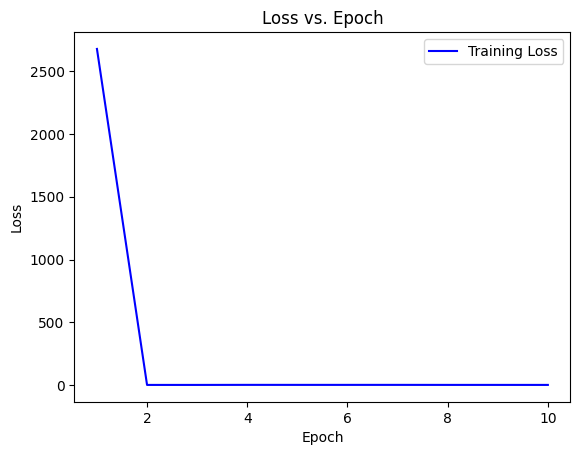

In [8]:
loss = history_lstm.history['loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'b', label='Training Loss')
plt.title('Loss vs. Epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()
model.save('Model_weights/lstm1.h5')


In [9]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error


def calculate_mape(actual, predicted):
    return np.mean(np.abs((actual - predicted) / (actual+1e-9))) * 100


def calculate_r_squared(actual, predicted):
    ss_residual = np.sum((actual - predicted) ** 2)
    ss_total = np.sum((actual - np.mean(actual)) ** 2)
    r_squared = 1 - (ss_residual / ss_total)
    return r_squared


lstm_predictions = model.predict(X_test)
lstm_rmse = np.sqrt(mean_squared_error(y_test, lstm_predictions))
lstm_mae = mean_absolute_error(y_test, lstm_predictions)
lstm_mape = calculate_mape(y_test, lstm_predictions)
lstm_r_squared = calculate_r_squared(y_test, lstm_predictions)
# Print the evaluation metrics
print("LSTM:")
print("RMSE:", lstm_rmse)
print("MAE:", lstm_mae)
print("MAPE:", lstm_mape)
print("R-squared:", lstm_r_squared)


2572/2572 [==============================] - 4s 1ms/step
LSTM:
RMSE: 5.39434958580051
MAE: 5.2444994594556835
MAPE: 2.9411162603866536
R-squared: 0.8096729827732537


In [10]:
input_shape = (10, 4)
X_input = Input(shape=input_shape)


data_normalizer = tf.keras.layers.Normalization(axis=-1)
data_normalizer.adapt(np.array(X_train))

X_normalized = data_normalizer(X_input)
X = X_normalized
X = LSTM(64, return_sequences=False)(X)
X = BatchNormalization()(X)
X = Dense(128, activation='relu')(X)
X = BatchNormalization()(X)
output = Dense(20)(X)


model = Model(inputs=X_input, outputs=output)
model.compile(optimizer='adam', loss=custom_loss)


In [11]:
history_lstm = model.fit(X_train, y_train, batch_size=128, epochs=10)

Epoch 1/10
2572/2572 [==============================] - 15s 5ms/step - loss: 2683.5867
Epoch 2/10
2572/2572 [==============================] - 13s 5ms/step - loss: 1.3744
Epoch 3/10
1404/2572 [===============>..............] - ETA: 5s - loss: 1.3187

In [ ]:
historyloss = history_lstm.history['loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'b', label='Training Loss')
plt.title('Loss vs. Epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()
model.save('Model_weights/lstm2.h5')

In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
def calculate_mape(actual, predicted):
    return np.mean(np.abs((actual - predicted) / (actual+1e-9))) * 100
def calculate_r_squared(actual, predicted):
    ss_residual = np.sum((actual - predicted) ** 2)
    ss_total = np.sum((actual - np.mean(actual)) ** 2)
    r_squared = 1 - (ss_residual / ss_total)
    return r_squared


lstm_predictions = model.predict(X_test)
lstm_rmse = np.sqrt(mean_squared_error(y_test, lstm_predictions))
lstm_mae = mean_absolute_error(y_test, lstm_predictions)
lstm_mape = calculate_mape(y_test, lstm_predictions)
lstm_r_squared = calculate_r_squared(y_test, lstm_predictions)
# Print the evaluation metrics
print("LSTM:")
print("RMSE:", lstm_rmse)
print("MAE:", lstm_mae)
print("MAPE:", lstm_mape)
print("R-squared:", lstm_r_squared)
